# Machine Learning Project - Wine Dataset

In this notebook, we will run an analysis of the Wine dataset, which contains the results of chemical analysis of wines produced by three different Italian winemakers. Our goal is to predict the type of wine based on its chemical values. Let's start by importing the necessary libraries and loading the dataset.

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

In [2]:
# loading the dataset
wine = load_wine()

Let's prepare the data for dataset analysis.

We will split the dataset into two sets: a training set (70% of the data) and a test set (30% of the data). Stratification based on the target variable (y) ensures that the class distribution in the training and in the test sets is representative of the distribution in the original dataset. This approach ensures that the model can be trained and evaluated accurately and reliably.

In [3]:
# data preparation
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
X = df_wine  # features
y = wine.target  # target

# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

For this analysis, we will use a Random Forest model to predict the class of wines in the Wine dataset.

The Random Forest model has been chosen for its ability to effectively handle datasets with many variables and its resilience to overfitting. This model works by aggregating multiple decision trees, each trained on a different subset of the dataset. The parameter `random_state=42` is set to ensure result reproducibility: this way, each model run with the same data will produce the same results.

In [4]:
# model definition
model = RandomForestClassifier(random_state=42)

To optimize the performance of our Random Forest model, we will define a parameter grid to be explored using the technique of hyperparameter tuning. This will allow us to identify the optimal combination of parameters to maximize the model's performance.

These hyperparameters include:
- **max_features**: The maximum number of features to consider for splitting each node.
- **max_depth**: The maximum depth of each decision tree in the forest.
- **min_samples_split**: The minimum number of samples required to split an internal node.
- **min_samples_leaf**: The minimum number of samples required to be in a leaf node.

Efficiency parameter:
- **n_estimators**: The number of trees in the forest.

In [5]:
# grid of parameter values to validate
param = [
    {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [50, 75, 100],
        'max_features': range(1, len(wine.feature_names))
    }
]

We search for the best values of the parameters using GridSearchCV.

In [6]:
# searching for optimal parameters using GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# best parameters found
best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best score during validation:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score during validation: 0.9923076923076923


The best identified parameters are:

- **max_depth=None**: Decision trees are fully expanded without depth limits.
- **max_features=1**: Each tree uses only one feature to make decisions when splitting nodes.
- **min_samples_leaf=1**: At least one sample is required to be in a leaf node.
- **min_samples_split=2**: At least two samples are required in an internal node to consider a split.
- **n_estimators=50**: The forest contains 50 decision trees.

The best validation score achieved was approximately 0.992, indicating a high accuracy of the model with this optimized combination of parameters.

---

Let's select the best model using the best identified parameters from the GridSearchCV. Afterwards, we will extract a single tree from the trained forest and visualize its structure.

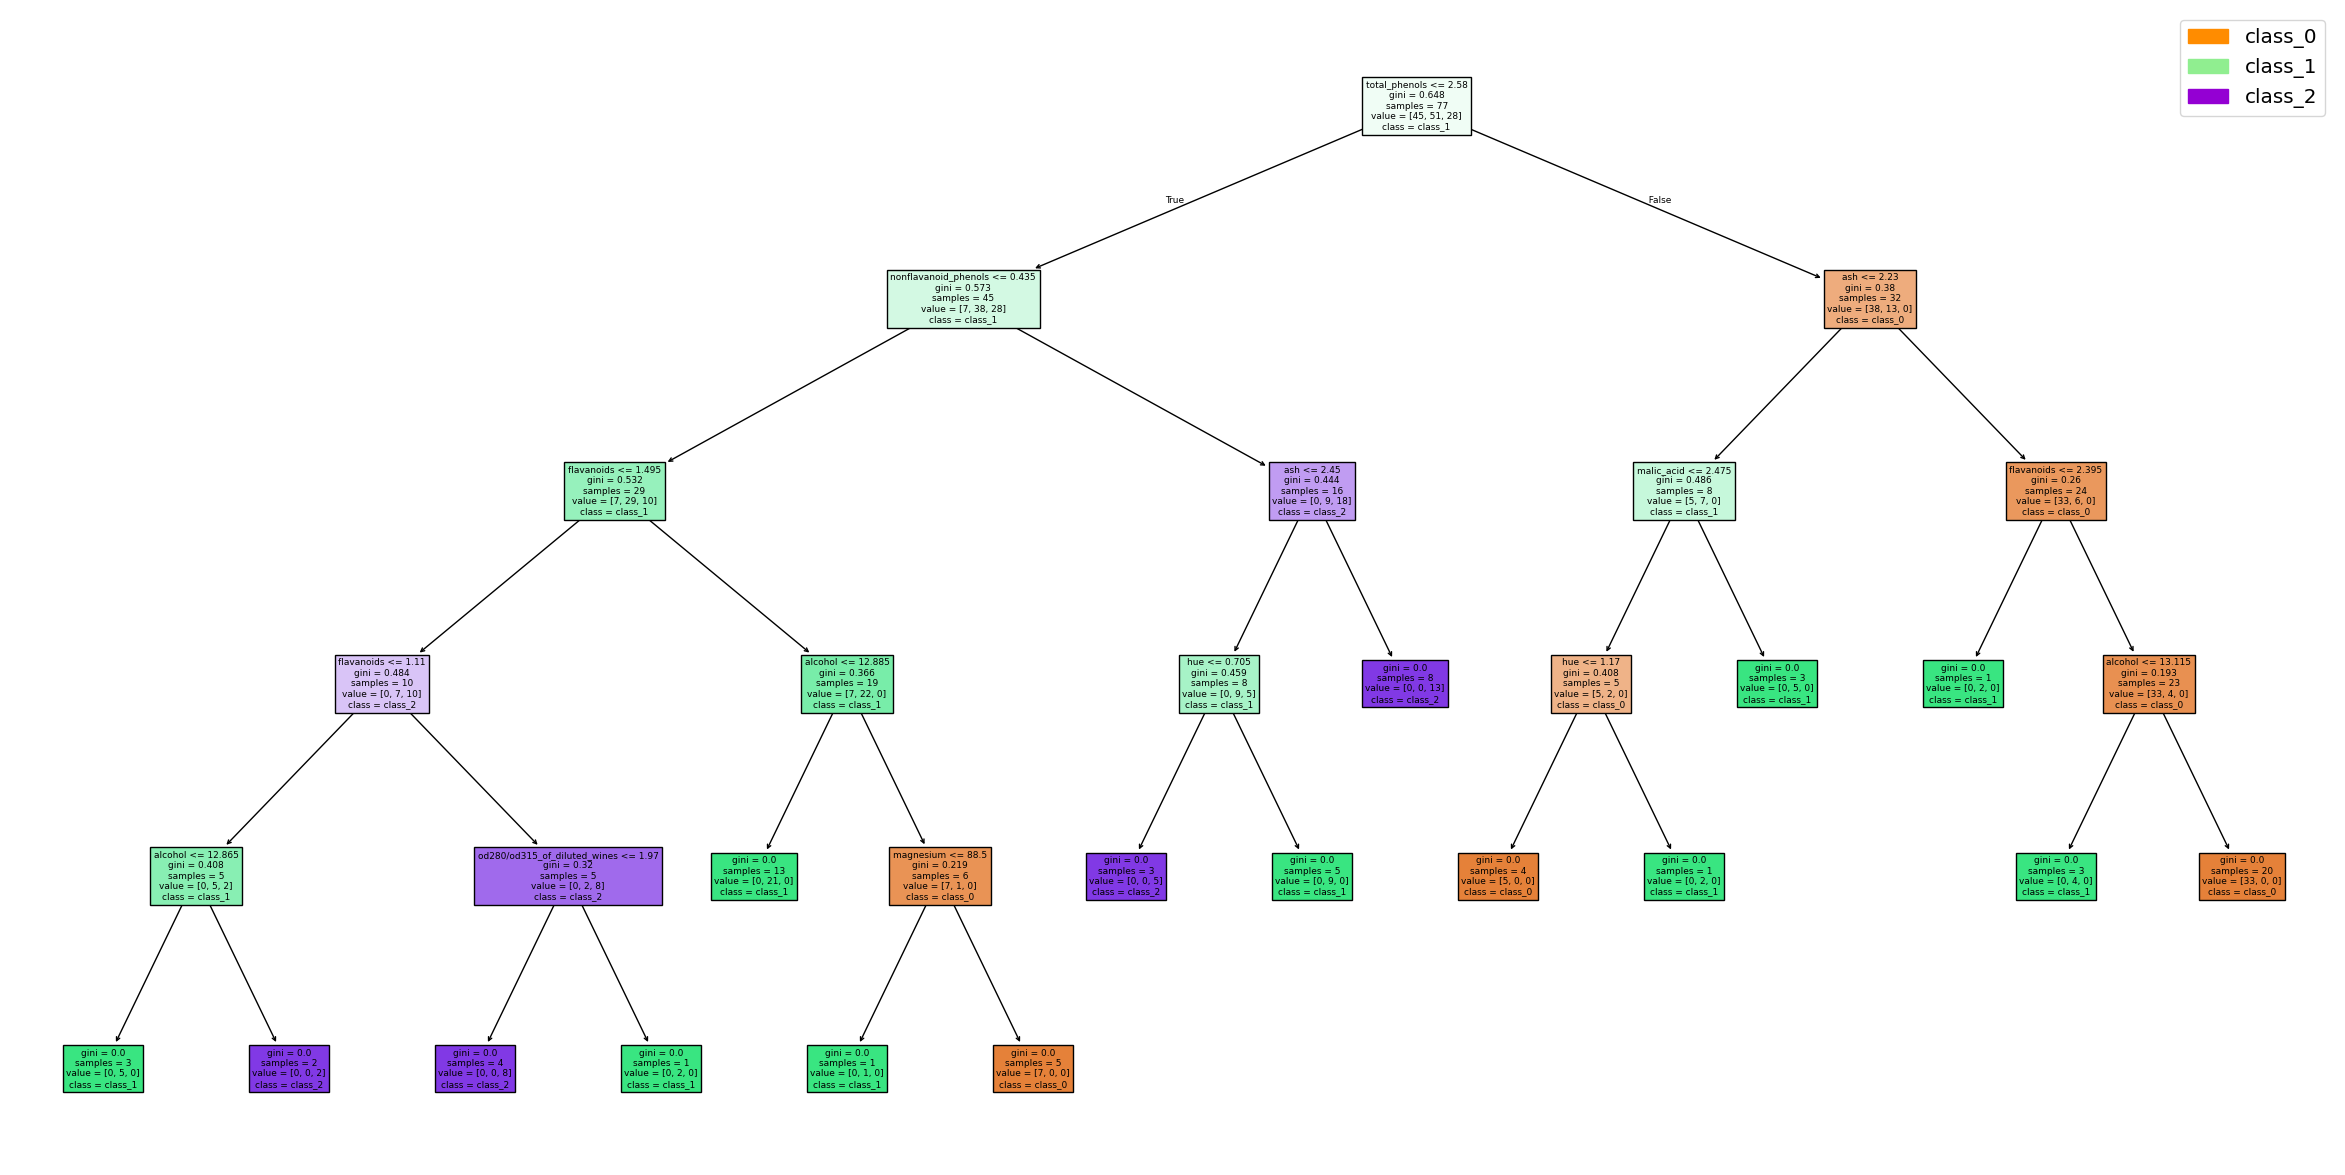

In [7]:
# best_model
best_model = grid_search.best_estimator_

# get a single tree from the Random Forest ensemble
single_tree = best_model.estimators_[0]

# visualize the tree with legend for class colors
plt.figure(figsize=(30, 15))
plot_tree(single_tree, filled=True, feature_names=wine.feature_names, class_names=wine.target_names)

# create legend handles using small colored rectangles for each class
handles = [plt.Rectangle((0,0),1,1,color=color, label=wine.target_names[i]) for i, color in enumerate(['darkorange', 'lightgreen', 'darkviolet'])]

# add legend with custom handles to the upper right corner with larger font size
plt.legend(handles=handles, loc='upper right', fontsize='x-large')
plt.show()

In order to evaluate the performance of the model, we can use a classification report and a confusion matrix, which provide a comprehensive view of the model's classification performance.

In [8]:
# model evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Model accuracy:", accuracy)
print(f'Classification Report:\n{report}')

Model accuracy: 0.9814814814814815
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



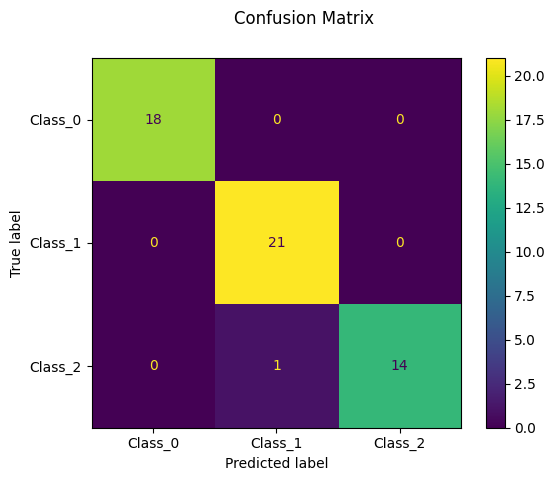

In [9]:
# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['Class_0', 'Class_1', 'Class_2'])
disp.figure_.suptitle("Confusion Matrix")
plt.show()

The Random Forest model trained with the best parameters achieved an accuracy of 98.15% on the test set.

From the confusion matrix, we can see that all samples were classified correctly except for one sample labeled as class_2 but was predicted as class_1.

This is also reflected in the classification report, where the only class with perfect precision and recall is class_0, while the precision for class_1 is less than 1 (indicating a false positive) and the recall for class_2 is less than 1 (indicating a false negative).

---

We graphically display the importance of the features to understand which ones were most important in the model's decision-making process.

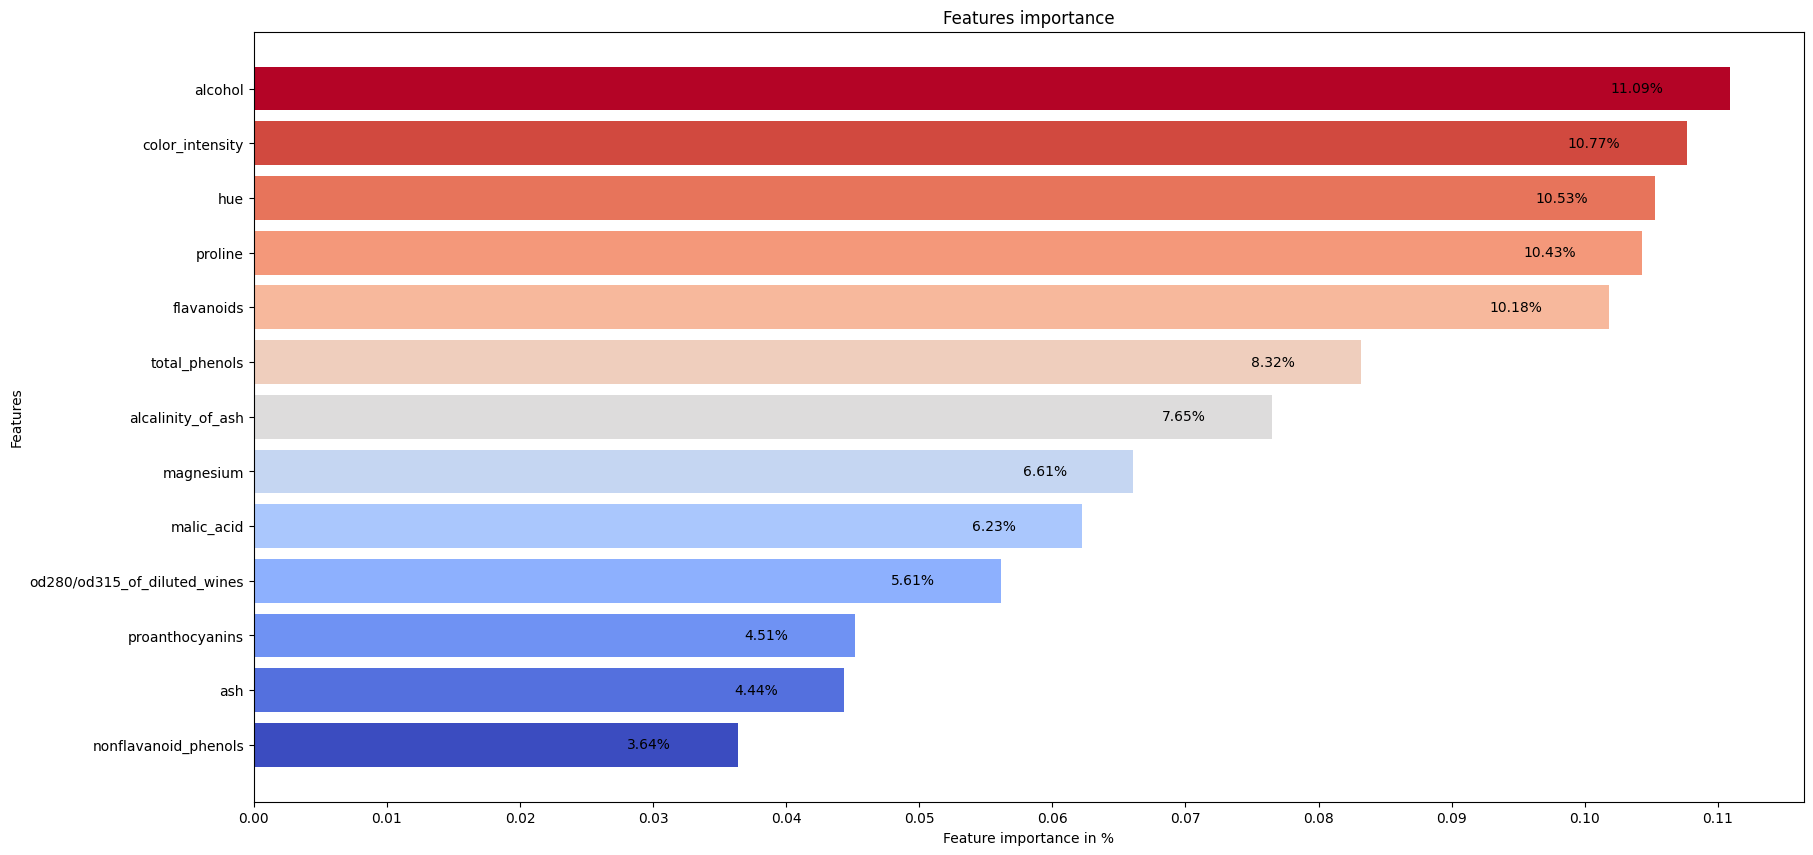

In [10]:
# get features importance from the best model
features_importance = best_model.feature_importances_

# create a DataFrame to store feature features_importance and sort by importance
features_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': features_importance}).sort_values(by='Importance', ascending=True)

# plot feature features_importance with customized color and inverted order
plt.figure(figsize=(20, 10))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(features_importance_df)))  # choose colormap

# create horizontal bar plot
bars = plt.barh(features_importance_df['Feature'], features_importance_df['Importance'], color=colors)

# add values as annotations on the bars
for bar, importance in zip(bars, features_importance_df['Importance']):
    plt.text(bar.get_width() - 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.2%}', 
             va='center', ha='right', color='black')

plt.xlabel('Feature importance in %')
plt.ylabel('Features')
plt.title('Features importance')

# set ticks on x-axis with a step of 0.01
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # set format for tick labels
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.01))  # set tick spacing

plt.show()

The most influential features in the decision-making process of the Random Forest model include alcohol with 11.09% importance, followed by color intensity (10.77%) and hue (10.53%). These attributes, along with proline (10.43%) and flavonoids (10.18%), play a fundamental role in classifying wine varieties.

However, it is important to note that feature importances computed on tree-based models have two potential drawbacks:

- **Training Dataset Information**: Feature importances are calculated using statistics derived from the training dataset, which may not necessarily reflect feature importance for making accurate predictions on a separate (hold-out) dataset.
  
- **Bias towards High-Cardinality Features**: Features with a high number of unique values (high cardinality) tend to be of major importance calculated by tree-based models, potentially leading to misleading conclusions about the true relevance of features in the context of model generalization.

These considerations let us to interpret features importance cautiously, considering the specific application context and carefully evaluating how features influence model performance on unseen data.

---

# Conclusions

During this process of analysis and training of the Random Forest model for wine variety classification, we have obtained significant results allowing us to draw the following conclusions:

- **Model Performance**: The trained optimal model demonstrated an accuracy of 98.15% on the test set, indicating a remarkable ability to generalize and predict wine varieties based on chemical characteristics.

- **Feature Importances**: Their analysis highlighted that the most influential features in the model's decision-making process are primarily:

    - Alcohol (11.09%)
    - Color Intensity (10.77%)
    - Hue (10.53%)
    - Proline (10.43%)
    - Flavonoids (10.18%)

    These chemical attributes were crucial in distinguishing and classifying wine varieties in the dataset.

However, it's important to consider some limitations associated with features importance computed on tree-based models. These include being based on the training dataset and potentially favoring high-cardinality features, which could lead to misleading conclusions about feature relevance for model generalization.

In conclusion, the trained Random Forest model has demonstrated excellent capabilities in classifying wine varieties. The most influential features provide valuable insights into the chemical characteristics driving distinctions among wine varieties. However, it's essential to examine such results while considering the limitations associated with features importance in order to correctly interpret the model's performance.